In [1]:
import sys
sys.path.append("../")

In [2]:
import pandas as pd 
import numpy as np
import os
import scanpy as sc
import torch

In [3]:
import statsmodels.api as sm

In [4]:
eta = pd.read_csv("../../Data/echidna3/MT_params/R310/eta.csv")
c_shape = pd.read_csv("../../Data/echidna3/MT_params/R310/c_shape.csv")
c_on = pd.read_csv("../../Data/echidna3/MT_params/R310/c_on.csv")
c_pre = pd.read_csv("../../Data/echidna3/MT_params/R310/c_pre.csv")

# PPC regression

In [5]:
from echidna.eval import sample_Eta
import pyro.distributions as dist

/Users/mingxuanzhang/anaconda3/envs/work/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
def sample_p_c_cond_eta(eta_mean, cov, c_shape, target_dim, target_timepoint, N=1000):
    eta_samples = sample_Eta(eta_mean, cov, target_dim, N) 
    c_rate = torch.mean(eta_samples, dim=0) 
    c_rate = torch.nn.functional.softplus(c_rate)
    c_shape = c_shape[target_timepoint, :, :].squeeze()
    c_samples = dist.Gamma(c_shape, 1/c_rate).sample([N])
    return eta_samples, c_samples

def conditional_var_c(c_samples):
    return torch.var(c_samples, dim=0)

def conditional_mean_c(c_samples):
    return torch.mean(c_samples, dim=0)

In [7]:
eta_mean = torch.tensor(np.array(eta[eta.columns[1:]]))
eta_mean.shape

torch.Size([23648, 11])

In [8]:
c_shape = torch.tensor(np.array(c_shape[c_shape.columns[1:]]))
c_shape.shape

torch.Size([23648, 2])

In [9]:
cov = torch.cov(eta_mean.T)
cov.shape

torch.Size([11, 11])

In [10]:
eta_samples, c_samples = sample_p_c_cond_eta(eta_mean, cov, c_shape.T.unsqueeze(1), 0, 1, N=1000)

In [11]:
c_cond_var = conditional_var_c(c_samples)
c_cond_var.shape

torch.Size([23648])

In [12]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'Log Conditional varaince of c')

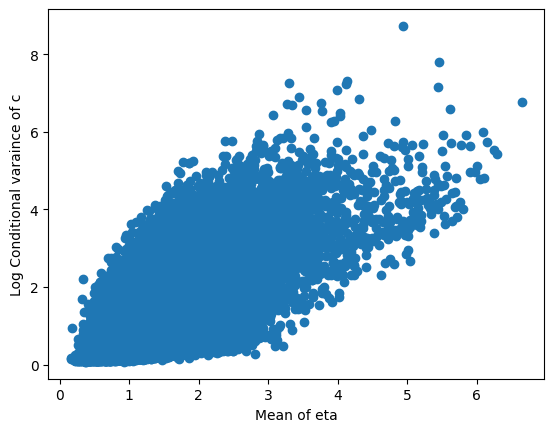

In [13]:
sample_eta_mean = torch.mean(eta_samples, dim=0)
plt.scatter(sample_eta_mean, torch.log1p(c_cond_var))
plt.xlabel("Mean of eta")
plt.ylabel("Log Conditional varaince of c")

In [14]:
import statsmodels.api as sm
import tqdm

In [16]:
num_genes = eta_samples.shape[1]
results = []

for gene in range(num_genes):
    eta_gene_samples = eta_samples[:, gene].numpy()
    c_gene_samples = c_samples[:, gene].numpy()

    X = sm.add_constant(eta_gene_samples)
    y = c_gene_samples
    model = sm.OLS(y, X).fit()

    r_squared = model.rsquared
    regression_coefficient = model.params[1]
    pval = model.pvalues[1]

    results.append({
        'gene': gene,
        'r_squared': r_squared,
        'regression_coefficient': regression_coefficient,
        'pval': pval
    })

In [17]:
import matplotlib.cm as cm

In [19]:
regression_coefficients = [result['regression_coefficient'] for result in results]
pvals = [result['pval'] for result in results]

In [20]:
log_pval = -np.log10(pvals)
log_pval.shape

(23648,)

In [21]:
df = pd.DataFrame()
df['weights'] = regression_coefficients
df['pval'] = log_pval

In [22]:
import seaborn as sns

In [33]:
import scipy

In [38]:
scipy.stats.iqr(regression_coefficients)

0.0505506280947793

In [34]:
lower = np.quantile(regression_coefficients, 0.25) - 1.5 * scipy.stats.iqr(regression_coefficients)
lower

-0.10106678586891191

In [35]:
upper = np.quantile(regression_coefficients, 0.75) + 1.5 * scipy.stats.iqr(regression_coefficients)
upper

0.10113572651020529

[]

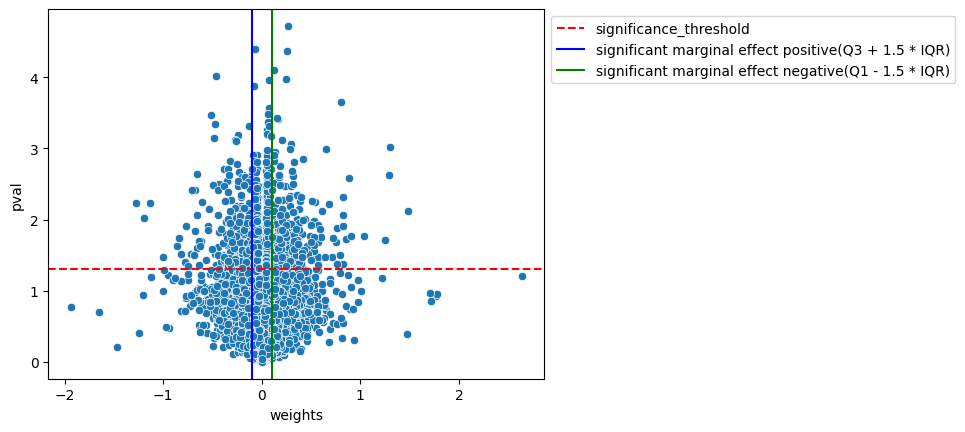

In [40]:
sns.scatterplot(x='weights', y='pval', data=df)
plt.axhline(y=-np.log10(0.05), color='red', linestyle='--', label='significance_threshold')
plt.axvline(x=lower, label='significant marginal effect positive(Q3 + 1.5 * IQR)', color='blue')
plt.axvline(x=upper, label='significant marginal effect negative(Q1 - 1.5 * IQR)', color='green')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.plot()

# Mutual information

In [4]:
eta = pd.read_csv("../../Data/echidna3/MT_params/R310/eta.csv")
c_on = pd.read_csv("../../Data/echidna3/MT_params/R310/c_on.csv")
c_pre = pd.read_csv("../../Data/echidna3/MT_params/R310/c_pre.csv")

In [5]:
eta[eta.columns[1:]]

,0,1,2,3,4,5,6,7,8,9,10
0,1.857223,2.060116,2.097698,2.585199,2.067527,2.225291,1.315922,2.259567,2.093008,1.681432,2.232714
1,2.053791,2.438833,2.171434,2.529050,1.878489,1.762162,2.441111,2.473394,2.283755,2.979206,1.703250
2,2.213112,1.527256,1.585210,1.528190,2.014703,1.977327,1.683342,1.599129,0.880800,1.786916,1.172631
3,1.848088,1.928763,1.874356,2.480344,2.275854,2.308906,1.443697,2.210113,3.219992,1.453442,2.630759
4,1.833106,2.168447,1.878510,1.724037,1.857546,1.719936,2.267303,1.534002,1.512896,1.967918,0.989828
...,...,...,...,...,...,...,...,...,...,...,...
23643,2.168248,2.322773,2.096913,1.664052,2.427132,2.101278,2.549503,2.429155,2.493852,1.795408,2.306846
23644,2.162406,2.560112,2.173461,1.932525,2.319613,1.728830,1.660074,2.321863,1.487421,2.494837,2.457637
23645,1.578118,1.704863,1.796519,2.440146,2.161476,1.698306,2.902744,1.073533,1.714534,2.351615,1.952178
23646,1.369119,1.978001,1.862012,2.484921,2.299806,1.490179,1.880306,1.478819,1.937056,1.850889,1.763710


In [6]:
from echidna.eval import sample_C, sample_Eta

/Users/mingxuanzhang/anaconda3/envs/work/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [110]:
from sklearn.neighbors import KernelDensity
import torch.distributions as dist
from concurrent.futures import ProcessPoolExecutor
import tqdm

In [52]:
from scipy.stats import gaussian_kde
from scipy.integrate import nquad

In [113]:
from joblib import Parallel, delayed

In [114]:
def sample_eta_c_joint(eta_mean, cov, c_shape, target_dim, target_timepoint, N=1000):
    eta_samples = sample_Eta(eta_mean, cov, target_dim, N) 
    c_rate = torch.mean(eta_samples, dim=0) 
    c_rate = torch.nn.functional.softplus(c_rate)
    c_shape = c_shape[target_timepoint, :, :].squeeze()
    c_samples = dist.Gamma(c_shape, 1/c_rate).sample([N]).numpy()
    eta_samples = eta_samples.numpy()
    return eta_samples, c_samples

def compute_mi_per_gene(eta_samples, c_samples):
    kde_eta = KernelDensity(kernel='gaussian',bandwidth='silverman').fit(eta_samples[:, None])
    kde_c = KernelDensity(kernel='gaussian', bandwidth='silverman').fit(c_samples[:, None])
    kde_eta_c = KernelDensity(kernel='gaussian', bandwidth='silverman').fit(np.vstack([eta_samples, c_samples]).T)
    log_p_eta = kde_eta.score_samples(eta_samples[:, None])
    log_p_c = kde_c.score_samples(c_samples[:, None])
    log_p_eta_c = kde_eta_c.score_samples(np.vstack([eta_samples, c_samples]).T)
    mi = np.mean(log_p_eta_c - log_p_eta - log_p_c)
    return mi

def compute_mi_all(eta, c):
    mis = []
    for i in tqdm.tqdm(range(eta.shape[-1])):
        mis.append(compute_mi_per_gene(eta[:, i], c[:, i]))
    return np.mean(mis)

def compute_mi_all_parallel(eta, c, n_jobs=-1):
    mi_values = Parallel(n_jobs=n_jobs)(
        delayed(compute_mi_per_gene)(eta[:, i], c[:, i]) for i in range(eta.shape[1])
    )
    return np.mean(mi_values)

In [169]:
import numpy as np
from sklearn.neighbors import NearestNeighbors

def MI_knn_approx(X, Y, k=5):
    XY = np.vstack((X, Y)).T
    nn = NearestNeighbors(n_neighbors=k)
    nn.fit(XY)
    distances, _ = nn.kneighbors(XY)
    kth_distances = distances[:, -1]
    nx = np.array([len(np.where(np.abs(X - X[i]) < kth_distances[i])[0]) for i in range(len(X))]) - 1
    ny = np.array([len(np.where(np.abs(Y - Y[i]) < kth_distances[i])[0]) for i in range(len(Y))]) - 1
    mi = np.mean(np.log((nx * ny) / (k - 1))) + np.log(len(X))

    return mi

def KNN_mi_all_parallel(eta, c, n_jobs=-1):
    mi_values = Parallel(n_jobs=n_jobs)(
        delayed(MI_knn_approx)(eta[:, i], c[:, i]) for i in range(eta.shape[1])
    )
    return np.mean(mi_values)

def posterior_MI_KNN(eta, c, num_permutations=1000, n_jobs=-1):
    observed_mi = KNN_mi_all_parallel(eta, c, n_jobs=n_jobs)

    # Permutation test
    permuted_mi = Parallel(n_jobs=n_jobs)(
        delayed(KNN_mi_all_parallel)(eta, np.random.permutation(c)) for _ in range(num_permutations)
    )
    print("Permuted MI values:")
    for i, mi in enumerate(permuted_mi):
        print(f"Permuted MI {i + 1}: {mi}")

    p_value = np.sum(np.array(permuted_mi) >= observed_mi) / num_permutations
    return observed_mi, p_value

In [172]:
def permutation_test_mi_debug(X, Y, num_permutations=10, k=5):
    # Compute observed MI
    observed_mi = KNN_mi_all_parallel(X, Y, n_jobs=-1)

    # Permutation test (simplified for debugging)
    permuted_mi = []
    for i in range(num_permutations):
        Y_permuted = np.random.permutation(Y)
        mi = KNN_mi_all_parallel(X, Y_permuted, n_jobs=-1)
        permuted_mi.append(mi)
        print(f"Permuted MI {i + 1}: {mi}")  # Print each permuted MI

    # Compute p-value
    p_value = np.sum(np.array(permuted_mi) >= observed_mi) / num_permutations

    return observed_mi, p_value


In [173]:
eta_mean = torch.tensor(np.array(eta[eta.columns[1:]]))
eta_mean.shape

torch.Size([23648, 11])

In [174]:
cov = torch.cov(eta_mean.T)
cov.shape

torch.Size([11, 11])

In [175]:
c_shape = torch.rand(2, 1, eta_mean.shape[0])
c_shape.shape

torch.Size([2, 1, 23648])

In [181]:
K = 3
T = 0

In [182]:
eta_samples, c_samples = sample_eta_c_joint(eta_mean, cov, c_shape, K, T, N=500)

In [187]:
eta_samples.shape

(500, 23648)

In [188]:
c_samples.shape

(500, 23648)

In [189]:
KNN_mi_all_parallel(eta_samples.T, c_samples.T, -1)

20.233154585380387

In [191]:
permutation_test_mi_debug(eta_samples.T, c_samples.T)

Permuted MI 1: 20.24077928830348
Permuted MI 2: 20.241573566312653
Permuted MI 3: 20.24133075862645


KeyboardInterrupt: 

# GLM fit for c vs eta

In [11]:
etas = pd.read_csv("../../Data/echidna3/mean_etas.csv")
etas = etas.set_index("Unnamed: 0")
etas.index.name = 'sig'
etas.head()

,0,clone,patient
sig,,,
MAPKi_INDUCED_EMT,2.655280,C0,F16
MAPKi_INDUCED_ANGIOGENESIS,3.484656,C0,F16
POST_OP_WOUNDHEALING,3.460031,C0,F16
MS_RESP_TO_WOUNDING_UP_IN_MAPKi_aPDL1_NR,2.519422,C0,F16
PH_BLOOD_VESS_DEVEL_DN_IN_R,3.325817,C0,F16


In [12]:
c = pd.read_csv("../../Data/echidna3/mean_c.csv")
c = c.set_index("Unnamed: 0")
c.index.name = 'sig'
c.head()

,0,clone,patient
sig,,,
MAPKi_INDUCED_EMT,-0.902955,C0,F16
MAPKi_INDUCED_ANGIOGENESIS,0.709286,C0,F16
POST_OP_WOUNDHEALING,0.096678,C0,F16
MS_RESP_TO_WOUNDING_UP_IN_MAPKi_aPDL1_NR,1.703340,C0,F16
PH_BLOOD_VESS_DEVEL_DN_IN_R,0.626407,C0,F16


In [15]:
c.shape

(5445, 3)

In [23]:
etas['clone'].unique()

array(['C0', 'C1', 'C2', 'C3'], dtype=object)

In [38]:
Patient = "F16"

In [73]:
def format_input(df):
    all_patients = df['patient'].unique()
    x = []
    for p in all_patients:
        df_p = df[df['patient'] == p]
        clones = df_p['clone'].unique()
        for c in clones:
            x.append(np.array(df_p[df_p['clone'] == c]['0']))
    x = np.vstack(x)
    return x

In [87]:
signatures = list(c.index.unique())

In [74]:
covariates = format_input(etas).T
covariates.shape

(363, 15)

In [75]:
responses = format_input(c).T
responses.shape

(363, 15)

In [76]:
n_sigs, n_clones = covariates.shape
print(n_sigs, n_clones)

363 15


In [77]:
import tqdm
import warnings

In [78]:
def fit_glm(responses, covariates):
    n_sigs, n_samples = responses.shape
    results = []
    for i in tqdm.tqdm(range(n_sigs)):
        with warnings.catch_warnings():
            glm = sm.GLM(responses[i, :], sm.add_constant(covariates[i, :]), family=sm.families.Gaussian())
            res = glm.fit()
            results.append(res)
    return results

In [79]:
results = fit_glm(responses, covariates)

100%|██████████| 363/363 [00:00<00:00, 3029.98it/s]


In [80]:
import matplotlib.pyplot as plt
from statsmodels.stats.multitest import multipletests

In [81]:
results[1].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                   15
Model:                            GLM   Df Residuals:                       13
Model Family:                Gaussian   Df Model:                            1
Link Function:               Identity   Scale:                         0.19480
Method:                          IRLS   Log-Likelihood:                -7.9424
Date:                Tue, 05 Mar 2024   Deviance:                       2.5324
Time:                        15:27:48   Pearson chi2:                     2.53
No. Iterations:                     3   Pseudo R-squ. (CS):            0.05539
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1503      0.233      0.644      0.519      -0.307       0.608
x1            -0.0729      0.087     -0.842      0.400      -0.243       0.097
==============================================================================
"""

In [110]:
betas, pvals = [], []
for res in results:
    betas.append(res.params[1:][0])
    pvals.append(res.pvalues[1:][0])

In [112]:
_, adjusted_p_values, _, _ = multipletests(pvals)
log_pval = np.clip(-np.log10(pvals), a_min=0, a_max=1000)
log_pval.shape

(363,)

In [130]:
df = pd.DataFrame()
df['sig'] = signatures
df['weights'] = betas
df['-log10_p'] = log_pval
df.head()

,sig,weights,-log10_p
0,MAPKi_INDUCED_EMT,-0.433262,0.204668
1,MAPKi_INDUCED_ANGIOGENESIS,-0.072861,0.397925
2,POST_OP_WOUNDHEALING,-0.140799,0.685315
3,MS_RESP_TO_WOUNDING_UP_IN_MAPKi_aPDL1_NR,-0.476606,0.378825
4,PH_BLOOD_VESS_DEVEL_DN_IN_R,-0.071066,0.307305


In [131]:
df.to_csv("glm_result.tsv", sep='\t')

In [114]:
df[df['-log10_p'] > -np.log10(0.05)]

,sig,weights,-log10_p
30,GO_AMEBOIDAL_TYPE_CELL_MIGRATION,-1.044668,1.956051
65,HALLMARK_APICAL_JUNCTION,-0.455169,1.380992
101,HALLMARK_PROTEIN_SECRETION,3.356333,1.512988
103,HALLMARK_SPERMATOGENESIS,-0.163865,1.479709
137,KEGG_BASE_EXCISION_REPAIR,1.149773,2.486513
150,KEGG_CITRATE_CYCLE_TCA_CYCLE,1.718264,2.263000
155,KEGG_CYTOSOLIC_DNA_SENSING_PATHWAY,0.851173,1.809732
165,KEGG_ERBB_SIGNALING_PATHWAY,-3.922731,1.310735
166,KEGG_ETHER_LIPID_METABOLISM,-0.691243,1.356873
189,KEGG_GLYOXYLATE_AND_DICARBOXYLATE_METABOLISM,2.059448,1.726030


In [115]:
import seaborn as sns

[]

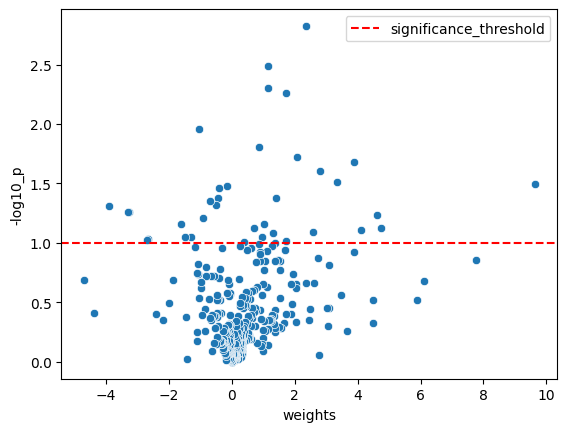

In [121]:
sns.scatterplot(x='weights', y='-log10_p', data=df)
plt.axhline(y=-np.log10(0.1), color='red', linestyle='--', label='significance_threshold')
plt.legend()
plt.plot()

In [127]:
df = df[df['weights'] > 0]
df_sig = df[df['-log10_p'] > -np.log10(0.1)]
df_sig = df_sig.sort_values(by='weights', ascending=False)
df_sig

,sig,weights,-log10_p
355,Anitgen_pres_pozniak,9.638934,1.497450
92,HALLMARK_MYC_TARGETS_V1,4.754045,1.127014
333,Baron_Stress_like,4.600273,1.231521
244,KEGG_PHOSPHATIDYLINOSITOL_SIGNALING_SYSTEM,4.120131,1.108904
315,HKG_Chang_etal_PlosOne_2011,3.896475,1.681243
101,HALLMARK_PROTEIN_SECRETION,3.356333,1.512988
223,KEGG_NON_HOMOLOGOUS_END_JOINING,2.817656,1.601247
253,KEGG_PROTEASOME,2.564800,1.091322
319,MINN_PRO,2.371244,2.824508
189,KEGG_GLYOXYLATE_AND_DICARBOXYLATE_METABOLISM,2.059448,1.726030


In [129]:
df = df[df['weights'] < 0]
df_sig = df[df['-log10_p'] > -np.log10(0.1)]
df_sig = df_sig.sort_values(by='weights', ascending=False)
df_sig

,sig,weights,-log10_p
103,HALLMARK_SPERMATOGENESIS,-0.163865,1.479709
282,KEGG_TGF_BETA_SIGNALING_PATHWAY,-0.396472,1.463981
65,HALLMARK_APICAL_JUNCTION,-0.455169,1.380992
325,VEER_INV,-0.500660,1.319407
166,KEGG_ETHER_LIPID_METABOLISM,-0.691243,1.356873
119,KEGG_ALDOSTERONE_REGULATED_SODIUM_REABSORPTION,-0.917925,1.210251
30,GO_AMEBOIDAL_TYPE_CELL_MIGRATION,-1.044668,1.956051
206,KEGG_LONG_TERM_DEPRESSION,-1.290942,1.050495
109,HALLMARK_WNT_BETA_CATENIN_SIGNALING,-1.488062,1.051413
151,KEGG_COLORECTAL_CANCER,-1.626143,1.156022
